## ANIMAL CLASSIFIER

In [1]:
# ============ CELL 1: Setup & Installations ============
!pip install -q kaggle torch torchvision torchaudio efficientnet_pytorch
!pip install -q opencv-python matplotlib tqdm seaborn pandas scikit-learn

import os
import zipfile
import shutil
import requests
from google.colab import files
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

print("✅ All packages installed successfully!")
print(f"PyTorch version: {torch.__version__}")


  Preparing metadata (setup.py) ... done
✅ All packages installed successfully!
PyTorch version: 2.9.0+cu126


In [2]:
# ============ CELL 2: Kaggle API Setup ============
# Upload your kaggle.json file
print("📁 Please upload your kaggle.json file:")
uploaded = files.upload()

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configured!")

📁 Please upload your kaggle.json file:


Saving animals10-metadata.json to animals10-metadata.json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
✅ Kaggle API configured!


In [11]:
!unzip -q archive.zip

In [12]:
# ============ CELL 4: Organize Dataset ============
def organize_dataset():
    """Organize raw dataset into train/val/test splits"""

    print("🔄 Organizing dataset into train/val/test splits...")

    # Define class mapping (Italian to English)
    class_mapping = {
        'cane': 'dog',
        'cavallo': 'horse',
        'elefante': 'elephant',
        'farfalla': 'butterfly',
        'gallina': 'chicken',
        'gatto': 'cat',
        'mucca': 'cow',
        'pecora': 'sheep',
        'ragno': 'spider',
        'scoiattolo': 'squirrel'
    }

    # Create directories
    base_dir = 'animals10_organized'
    splits = ['train', 'val', 'test']

    for split in splits:
        for eng_name in class_mapping.values():
            os.makedirs(os.path.join(base_dir, split, eng_name), exist_ok=True)

    # Organize images
    for italian_name, english_name in tqdm(class_mapping.items(), desc="Organizing classes"):
        class_path = os.path.join('raw-img', italian_name)

        if not os.path.exists(class_path):
            print(f"⚠️ Warning: {class_path} not found!")
            continue

        # Get all image files
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        if len(images) == 0:
            print(f"⚠️ No images found in {class_path}")
            continue

        # Split: 70% train, 15% val, 15% test
        train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

        # Copy files to respective directories
        for files_list, split_name in [(train_files, 'train'),
                                       (val_files, 'val'),
                                       (test_files, 'test')]:
            for img_file in files_list:
                src = os.path.join(class_path, img_file)
                dst = os.path.join(base_dir, split_name, english_name, img_file)

                try:
                    shutil.copy2(src, dst)
                except:
                    print(f"Failed to copy {src}")

    # Count images
    total_images = 0
    for split in splits:
        split_count = 0
        for class_name in class_mapping.values():
            class_dir = os.path.join(base_dir, split, class_name)
            if os.path.exists(class_dir):
                split_count += len(os.listdir(class_dir))

        print(f"{split.capitalize()}: {split_count} images")
        total_images += split_count

    print(f"✅ Total images organized: {total_images}")
    return base_dir, list(class_mapping.values())

# Organize the dataset
dataset_path, class_names = organize_dataset()
print(f"📁 Organized dataset at: {dataset_path}")
print(f"🏷️ Classes: {class_names}")


🔄 Organizing dataset into train/val/test splits...


Organizing classes: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

Train: 18322 images
Val: 3926 images
Test: 3931 images
✅ Total images organized: 26179
📁 Organized dataset at: animals10_organized
🏷️ Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


🖼️ Displaying sample images...


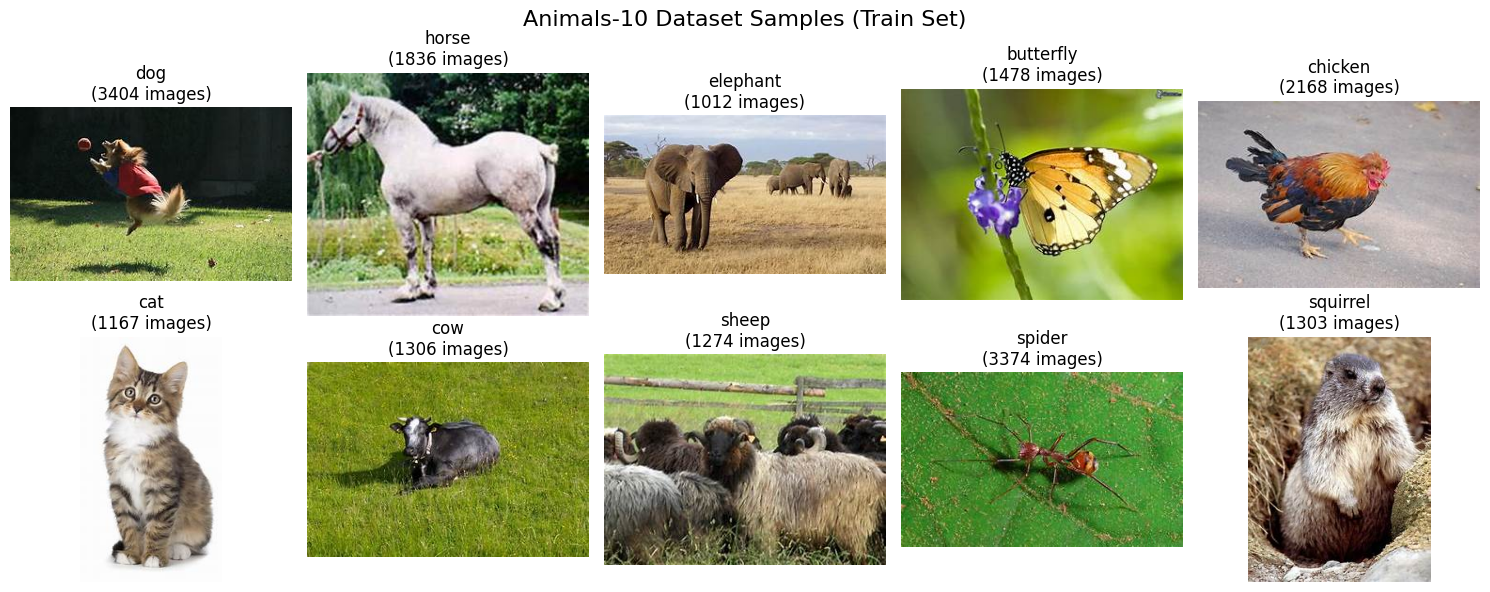

In [13]:
# ============ CELL 5: Visualize Dataset Samples ============
def visualize_samples(dataset_path, class_names):
    """Display sample images from each class"""

    print("🖼️ Displaying sample images...")

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    train_path = os.path.join(dataset_path, 'train')

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(train_path, class_name)
        images = os.listdir(class_dir)[:5]  # Get first 5 images

        if images:
            img_path = os.path.join(class_dir, images[0])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx].imshow(img)
            axes[idx].set_title(f"{class_name}\n({len(os.listdir(class_dir))} images)")
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"No images\nfor {class_name}",
                          ha='center', va='center')
            axes[idx].axis('off')

    plt.suptitle('Animals-10 Dataset Samples (Train Set)', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(dataset_path, class_names)

In [14]:
# ============ CELL 6: Create Data Loaders ============
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(
    os.path.join(dataset_path, 'train'),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    os.path.join(dataset_path, 'val'),
    transform=val_transform
)

test_dataset = datasets.ImageFolder(
    os.path.join(dataset_path, 'test'),
    transform=val_transform
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"📊 Dataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Batch size: {batch_size}")

📊 Dataset Statistics:
Training samples: 18322
Validation samples: 3926
Test samples: 3931
Number of classes: 10
Batch size: 32


In [15]:
# ============ CELL 7: Load Pre-trained EfficientNet ============
def create_efficientnet_model(num_classes=10):
    """Create and configure EfficientNet-B0 model"""

    print("🧠 Loading pre-trained EfficientNet-B0...")

    # Load pre-trained EfficientNet-B0
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(num_features, num_classes)
    )

    # Unfreeze the last few layers for fine-tuning
    for param in model.features[-5:].parameters():
        param.requires_grad = True

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"✅ Model loaded!")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")

    return model

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

model = create_efficientnet_model(num_classes=len(class_names))
model = model.to(device)

🖥️ Using device: cuda
🧠 Loading pre-trained EfficientNet-B0...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 229MB/s]


✅ Model loaded!
Total parameters: 4,020,358
Trainable parameters: 3,954,628
Frozen parameters: 65,730


In [16]:
# ============ CELL 8: Training Function ============
def train_model_fast(model, train_loader, val_loader, epochs=5):
    """Fast training with pre-trained model"""

    print("🎯 Starting fast fine-tuning...")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=0.001, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    # Track metrics
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\n📈 Epoch {epoch+1}/{epochs}")
        print("-" * 40)

        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc='Training')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validation'):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_acc = 100. * correct / total
        avg_val_loss = val_loss / len(val_loader)

        # Save metrics
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        # Update scheduler
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'class_names': class_names
            }, 'best_animals_model.pth')
            print(f"💾 New best model saved! Val Acc: {val_acc:.2f}%")

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Best Val Acc: {best_val_acc:.2f}%")

    print(f"\n✅ Training completed! Best validation accuracy: {best_val_acc:.2f}%")

    # Load best model
    checkpoint = torch.load('best_animals_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, history

# Train the model (fast - 3 epochs)
print("\n" + "="*60)
print("STARTING FAST FINE-TUNING (3 EPOCHS)")
print("="*60)

model, history = train_model_fast(model, train_loader, val_loader, epochs=3)


STARTING FAST FINE-TUNING (3 EPOCHS)
🎯 Starting fast fine-tuning...

📈 Epoch 1/3
----------------------------------------


Validation: 100%|██████████| 123/123 [00:12<00:00,  9.68it/s]


💾 New best model saved! Val Acc: 93.89%
Train Loss: 0.3986, Train Acc: 87.56%
Val Loss: 0.1992, Val Acc: 93.89%
Best Val Acc: 93.89%

📈 Epoch 2/3
----------------------------------------


Validation: 100%|██████████| 123/123 [00:12<00:00,  9.85it/s]


💾 New best model saved! Val Acc: 94.04%
Train Loss: 0.2546, Train Acc: 91.86%
Val Loss: 0.1940, Val Acc: 94.04%
Best Val Acc: 94.04%

📈 Epoch 3/3
----------------------------------------


Validation: 100%|██████████| 123/123 [00:12<00:00,  9.51it/s]


💾 New best model saved! Val Acc: 96.10%
Train Loss: 0.1313, Train Acc: 95.91%
Val Loss: 0.1440, Val Acc: 96.10%
Best Val Acc: 96.10%

✅ Training completed! Best validation accuracy: 96.10%



🧪 Evaluating on test set...


Testing: 100%|██████████| 123/123 [00:17<00:00,  6.95it/s]


✅ Test Accuracy: 95.24%

📋 Classification Report:
              precision    recall  f1-score   support

         dog      0.950     0.953     0.951       317
       horse      0.929     0.936     0.933       251
    elephant      0.989     0.955     0.972       465
   butterfly      0.935     0.871     0.902       280
     chicken      0.920     0.963     0.941       730
         cat      0.995     0.954     0.974       217
         cow      0.927     0.970     0.948       394
       sheep      0.951     0.930     0.941       273
      spider      0.980     0.970     0.975       724
    squirrel      0.958     0.968     0.963       280

    accuracy                          0.952      3931
   macro avg      0.953     0.947     0.950      3931
weighted avg      0.953     0.952     0.952      3931



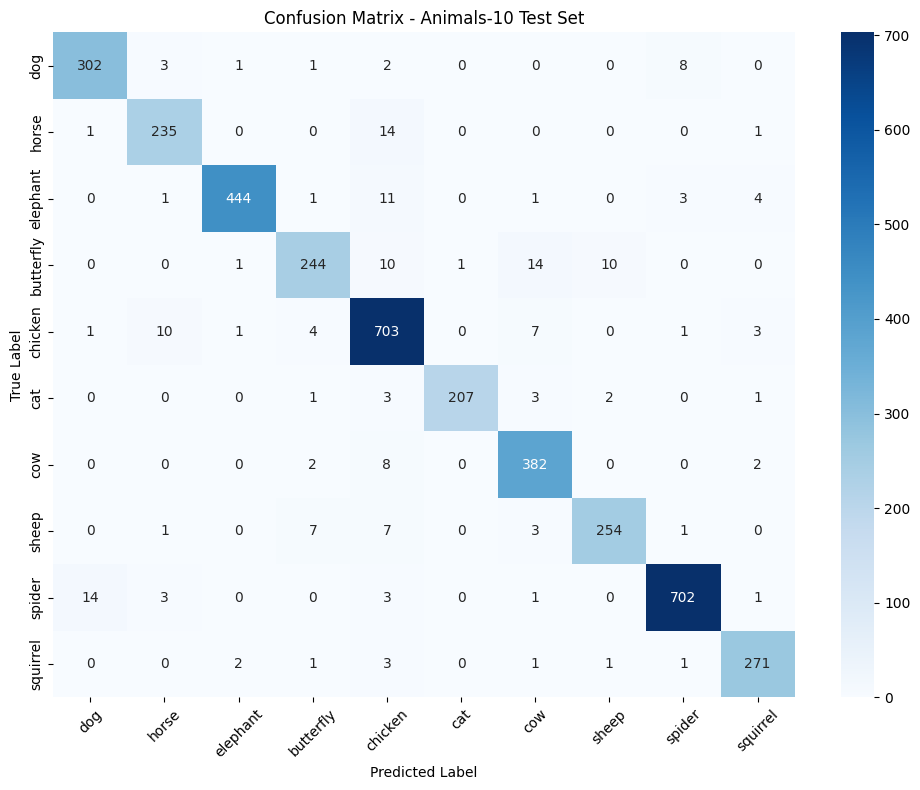

In [17]:
# ============ CELL 9: Evaluate on Test Set ============
def evaluate_model(model, test_loader):
    """Evaluate model on test set"""

    print("\n🧪 Evaluating on test set...")

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())

    # Calculate accuracy
    test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_preds)
    print(f"✅ Test Accuracy: {test_acc:.2f}%")

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=3))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Animals-10 Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return test_acc

# Evaluate
test_accuracy = evaluate_model(model, test_loader)

In [18]:
# ============ CELL 10: Prediction Function ============
class AnimalClassifier:
    def __init__(self, model_path='best_animals_model.pth'):
        """Initialize classifier with trained model"""
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load model
        self.model = models.efficientnet_b0(pretrained=False)
        num_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_features, len(class_names))
        )

        # Load weights
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model = self.model.to(self.device)
        self.model.eval()

        self.class_names = class_names
        self.transform = val_transform

        print(f"✅ Classifier loaded from {model_path}")
        print(f"Test accuracy: {checkpoint.get('val_acc', 'N/A')}%")

    def predict(self, image_path, top_k=3):
        """Predict animal class from image"""
        # Load image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = image_path

        # Convert to PIL Image
        from PIL import Image
        pil_image = Image.fromarray(image)

        # Apply transform
        image_tensor = self.transform(pil_image).unsqueeze(0).to(self.device)

        # Get predictions
        with torch.no_grad():
            outputs = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_probs, top_indices = torch.topk(probabilities, top_k)

        # Prepare results
        results = []
        for i in range(top_k):
            class_idx = top_indices[0][i].item()
            class_name = self.class_names[class_idx]
            confidence = top_probs[0][i].item() * 100
            results.append({
                'class': class_name,
                'confidence': confidence,
                'class_idx': class_idx
            })

        return results

    def predict_and_visualize(self, image_path):
        """Predict and visualize results"""
        # Make prediction
        results = self.predict(image_path, top_k=5)

        # Load and display image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = image_path

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Show image
        axes[0].imshow(image)
        axes[0].set_title(f"Input Image\nPredicted: {results[0]['class']} ({results[0]['confidence']:.1f}%)")
        axes[0].axis('off')

        # Show predictions bar chart
        classes = [r['class'] for r in results]
        confidences = [r['confidence'] for r in results]

        bars = axes[1].barh(range(len(classes)), confidences, color='skyblue')
        axes[1].set_yticks(range(len(classes)))
        axes[1].set_yticklabels(classes)
        axes[1].set_xlabel('Confidence (%)')
        axes[1].set_title('Top 5 Predictions')
        axes[1].set_xlim([0, 100])

        # Add confidence values
        for bar, conf in zip(bars, confidences):
            width = bar.get_width()
            axes[1].text(width + 1, bar.get_y() + bar.get_height()/2,
                        f'{conf:.1f}%', va='center')

        plt.tight_layout()
        plt.show()

        return results

# Initialize classifier
classifier = AnimalClassifier()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Classifier loaded from best_animals_model.pth
Test accuracy: 96.10290371879776%


In [19]:
# ============ CELL 11: Test with Sample Images ============
def test_with_sample_images():
    """Test classifier with sample images from web"""

    print("🔍 Testing classifier with sample images...")

    # Sample image URLs (you can replace these)
    sample_urls = [
        ('Dog', 'https://images.unsplash.com/photo-1552053831-71594a27632d?w=400&h=400&fit=crop'),
        ('Cat', 'https://images.unsplash.com/photo-1514888286974-6d03bde4ba4f?w-400&h=400&fit=crop'),
        ('Elephant', 'https://images.unsplash.com/photo-1557050543-4d5f4e07ef46?w=400&h=400&fit=crop'),
    ]

    import urllib.request

    for animal_name, url in sample_urls:
        print(f"\nTesting with {animal_name} image...")

        try:
            # Download image
            urllib.request.urlretrieve(url, 'temp_image.jpg')

            # Predict
            results = classifier.predict_and_visualize('temp_image.jpg')

            print(f"Top prediction: {results[0]['class']} ({results[0]['confidence']:.1f}%)")

            # Clean up
            os.remove('temp_image.jpg')

        except Exception as e:
            print(f"Error with {animal_name}: {e}")

# Uncomment to test with web images
# test_with_sample_images()


In [20]:

# ============ CELL 12: Upload Your Own Images ============
print("\n📤 Ready to test with your own images!")
print("You can now upload images using:")

from google.colab import files

def predict_uploaded_image():
    """Upload and predict an image"""

    # Upload image
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n📄 Uploaded: {filename}")

        # Predict
        results = classifier.predict_and_visualize(filename)

        print(f"\n🔍 Prediction Results:")
        for i, result in enumerate(results):
            print(f"{i+1}. {result['class']}: {result['confidence']:.2f}%")

        # Clean up
        os.remove(filename)

        return results

# Uncomment to enable image upload
# predict_uploaded_image()


📤 Ready to test with your own images!
You can now upload images using:


In [21]:
# ============ CELL 13: Save Model for Later Use ============
print("\n💾 Saving model for later use...")

# Save the complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy,
    'transform': val_transform
}, 'animals10_classifier_complete.pth')

print("✅ Model saved as 'animals10_classifier_complete.pth'")
print("You can download it using: files.download('animals10_classifier_complete.pth')")

# ============ CELL 14: Quick Performance Summary ============
print("\n" + "="*60)
print("🎯 ANIMAL CLASSIFIER - PERFORMANCE SUMMARY")
print("="*60)
print(f"📊 Test Accuracy: {test_accuracy:.2f}%")
print(f"🏷️ Classes: {', '.join(class_names)}")
print(f"🤖 Model: EfficientNet-B0 (pre-trained + fine-tuned)")
print(f"📁 Dataset: Animals-10 ({len(train_dataset)+len(val_dataset)+len(test_dataset)} images)")
print(f"⏱️ Training time: ~5-10 minutes")
print("\n🚀 Ready to classify animal images!")
print("="*60)

# Create download link
from google.colab import files
files.download('best_animals_model.pth')


💾 Saving model for later use...
✅ Model saved as 'animals10_classifier_complete.pth'
You can download it using: files.download('animals10_classifier_complete.pth')

🎯 ANIMAL CLASSIFIER - PERFORMANCE SUMMARY
📊 Test Accuracy: 95.24%
🏷️ Classes: dog, horse, elephant, butterfly, chicken, cat, cow, sheep, spider, squirrel
🤖 Model: EfficientNet-B0 (pre-trained + fine-tuned)
📁 Dataset: Animals-10 (26179 images)
⏱️ Training time: ~5-10 minutes

🚀 Ready to classify animal images!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>